# imports

In [ ]:
#forest 6.22.22
F4=(39.405312,-120.123955, 'Tahoe National Forest')

In [32]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopy
from geopy import distance
import math

import scipy
from scipy import stats
from itertools import combinations

from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special
from scipy import spatial

import figurefirst as fifi
import time



# spatial analysis
'''
function for determining distance between sensors
function for finding difference in direction, speed, etc

'''

In [1020]:
def spatialchanges (dir_df, speed_df, x_position,y_position,z_position, radians=False):
    '''
this takes the difference between 2 sensors for all possible combinations. Returns a df sorted by distance
    
    dir_df - all columns of directional data from one data collection, assumed to be in range 0-360
    
    speed_df - all columns of horizontal speed data from one data collection
    
    latlons - list of tuples in form (lat, lon) which correspond to dir_df and speed_df

all inputs are expected to be organized alphabetically/numerically from sensor A (1) to I (9) 
    
    '''    
    def combine(arr, s):  #to determine total permutation of sensor pairs
        return list(combinations(arr, s)) 
    
    ########this is for direction 
    if (radians==True): #to convert into degrees if needed
        dir_df=dir_df*180/np.pi
    if (any(np.max(dir_df)) > 360 or any(np.max(dir_df)) < 0):
        raise ValueError ("Directional data not bounded correctly. Needs to be in range [0,360] or [0,2pi]")
    
    
    columns=np.arange(0,len(dir_df.T)) #count total number of sensor recordings in df - should be same for S2, direction and position dfs
    N=len(combine(columns, 2)) #compute total number of permutations for all 2 sensor pairs
    direction_diff_list=np.empty((N, 0)).tolist()
    speed_diff_list=np.empty((N, 0)).tolist()
    direction_avg_list=np.empty((N, 0)).tolist()
    speed_avg_list=np.empty((N, 0)).tolist()
    distances=np.empty((N, 0)).tolist()
    k=0
    
    for i in columns:
        totalcombinations=len(dir_df.T)-i
        for j in range (1, totalcombinations):
            
            direction_diff_list[k]=np.abs(dir_df.iloc[:,i]-dir_df.iloc[:,i+j]) #direction_diff
            speed_diff_list[k]=speed_df.iloc[:,i]-speed_df.iloc[:,i+j] #speed_diff
            speed_avg_list[k]=(np.abs(speed_df.iloc[:,i]+speed_df.iloc[:,i+j])/2) #gives average speed between two sensors
            
            angulardata=np.array([dir_df.iloc[:,i],dir_df.iloc[:,i+j]])
            direction_avg_list[k]=scipy.stats.circmean(angulardata*math.pi/180, axis=0)*180/math.pi #computes mean between 2 sensors at each time recording
            
            u=np.array([x_position.iloc[0,i],y_position.iloc[0,i],x_position.iloc[0,i]]) #sensor1
            v=np.array([x_position.iloc[0,i+j],y_position.iloc[0,i+j],x_position.iloc[0,i+j]]) #sensor2
            distances[k]= scipy.spatial.distance.euclidean(u,v)*1000 #distance between sensor1 and sensor2 in meters

            #distances[k]=distance.distance(latlons[i],latlons[i+j]).m #compute distance in meters from gps coords
            k=k+1

    direction_diff=pd.DataFrame(direction_diff_list, index=np.round(distances,decimals=2))
    
    #fixes the angles
    M=len(direction_diff)
    for x in range (0,M):
        for y in (np.where(direction_diff_list[x]>180)):
            direction_diff.iloc[x,y]=360-direction_diff.iloc[x,y] #maximum difference in angle can be 180 - if more than 180, will subtract to get the smaller angle
    
    direction_diff=direction_diff.sort_index(ascending=True).T
    
    direction_avg=pd.DataFrame(direction_avg_list, index=np.round(distances,decimals=2)).sort_index(ascending=True).T
    speed_diff=pd.DataFrame(speed_diff_list, index=np.round(distances,decimals=2)).sort_index(ascending=True).T  
    speed_avg=pd.DataFrame(speed_avg_list, index=np.round(distances,decimals=2)).sort_index(ascending=True).T       
    
    return (direction_diff, direction_avg, speed_diff, speed_avg)


In [285]:
#split speed and difference dfs so that you can find averages on different time chunks
def split_df(df, chunk_size = 6000): #default chunks are 10 min
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks 

def avg_df(chunks):
    avg_df=pd.DataFrame(index=chunks[0].columns)
    N=len(chunks)
    if len(chunks[-1])< len(chunks[0]):
        N=len(chunks)-1
    testdf=np.empty((N, 0)).tolist()
    for i in range(0,N):
        testdf[i]=pd.DataFrame(chunks[i].mean(), columns=[i])
        avg_df=pd.concat([avg_df, testdf[i]], axis=1)
    return avg_df

def avg_df_direction(chunks):
    avg_df=pd.DataFrame(index=chunks[0].columns)
    N=len(chunks)
    if len(chunks[-1])< len(chunks[0]):
        N=len(chunks)-1
    testdf=np.empty((N, 0)).tolist()    
    for i in range(0,N):
        testdf[i]=pd.DataFrame((scipy.stats.circmean(chunks[i]*np.pi/180, axis=0)*180/np.pi), columns=[i], index=chunks[0].columns)
        avg_df=pd.concat([avg_df, testdf[i]], axis=1)
    return avg_df

def find_avg_values(direction_diff, direction_avg, speed_diff, speed_avg):
    new_direction_diff=avg_df(split_df(direction_diff))
    new_direction_avg=avg_df_direction(split_df(direction_avg))
    new_speed_diff=avg_df(split_df(speed_diff))
    new_speed_avg=avg_df(split_df(speed_avg))
    
    return new_direction_diff, new_direction_avg, new_speed_diff,new_speed_avg

# read in data

In [1249]:
#our wind data
df=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/raw data for me/small_6.22.22_maskedgpsdata.hdf')
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.time.iloc[0]))

'2022-06-22 11:33:23'

In [1250]:
#check for nan before running anything
df.isnull().values.any()

False

In [1251]:
print(df.keys())

Index(['time', 'S2_2', 'D_2', 'X_2', 'Y_2', 'Z_2', 'S2_3', 'D_3', 'X_3', 'Y_3',
       'Z_3', 'S2_4_verticallyorientated', 'D_4_verticallyorientated',
       'X_4_verticallyorientated', 'Y_4_verticallyorientated',
       'Z_4_verticallyorientated', 'S2_5', 'D_5', 'X_5', 'Y_5', 'Z_5', 'S2_6',
       'D_6', 'X_6', 'Y_6', 'Z_6', 'S2_7', 'D_7', 'X_7', 'Y_7', 'Z_7', 'S2_8',
       'D_8', 'X_8', 'Y_8', 'Z_8', 'S2_9_verticallyorientated',
       'D_9_verticallyorientated', 'X_9_verticallyorientated',
       'Y_9_verticallyorientated', 'Z_9_verticallyorientated',
       'U_4_verticallyorientated', 'V_4_verticallyorientated',
       'U_9_verticallyorientated', 'V_9_verticallyorientated'],
      dtype='object')


In [1252]:
'''
desert 10.20.20

#create separate dfs - (1) horizontal direction, (2) horizontal speed, (3) x position, (4) y position,(5) z position
df_dir=df[['D_1','D_2', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9']]
df_speeds=df[[ 'S2_1', 'S2_2', 'S2_4', 'S2_5','S2_6', 'S2_7', 'S2_8', 'S2_9']]
df_x=df[['X_1','X_2','X_4', 'X_5', 'X_6', 'X_7',  'X_8', 'X_9']]
df_y=df[['Y_1','Y_2', 'Y_4', 'Y_5','Y_6', 'Y_7',  'Y_8', 'Y_9']]
df_z=df[['Z_1','Z_2', 'Z_4', 'Z_5','Z_6','Z_7','Z_8', 'Z_9']]



#forest 7.7.21

#create separate dfs - (1) horizontal direction, (2) horizontal speed, (3) x position, (4) y position,(5) z position
df_dir=df[['D_1','D_2', 'D_3', 'D_5', 'D_6',  'D_8', 'D_9']]
df_speeds=df[[ 'S2_1', 'S2_2', 'S2_3', 'S2_5','S2_6', 'S2_8', 'S2_9']]
df_x=df[['X_1','X_2','X_3', 'X_5', 'X_6', 'X_8', 'X_9']]
df_y=df[['Y_1','Y_2', 'Y_3', 'Y_5','Y_6', 'Y_8', 'Y_9']]
df_z=df[['Z_1','Z_2', 'Z_3', 'Z_5','Z_6','Z_8', 'Z_9']]



#create separate dfs - (1) horizontal direction, (2) horizontal speed, (3) x position, (4) y position,(5) z position
df_dir=df[['D_1','D_2',   'D_6',   'D_8']] # 'D_9']]
df_speeds=df[[ 'S2_1', 'S2_2', 'S2_6',  'S2_8']] # 'S2_9']]
df_x=df[['X_1','X_2', 'X_6',  'X_8']] #, 'X_9']]
df_y=df[['Y_1','Y_2', 'Y_6',  'Y_8']] #, 'Y_9']]
df_z=df[['Z_1','Z_2','Z_6', 'Z_8']] #, 'Z_9']]

#create separate dfs - (1) horizontal direction, (2) horizontal speed, (3) x position, (4) y position,(5) z position
df_dir=df[['D_2',   'D_5', 'D_6',  'D_7',  'D_8']] # 'D_9']]
df_speeds=df[[  'S2_2', 'S2_5','S2_6', 'S2_7', 'S2_8']] # 'S2_9']]
df_x=df[['X_2',  'X_5', 'X_6', 'X_7',  'X_8']] #, 'X_9']]
df_y=df[['Y_2',   'Y_5','Y_6', 'Y_7', 'Y_8']] #, 'Y_9']]
df_z=df[['Z_2',    'Z_5','Z_6', 'Z_7', 'Z_8']] #, 'Z_9']]

'''

#create separate dfs - (1) horizontal direction, (2) horizontal speed, (3) x position, (4) y position,(5) z position
df_dir=df[['D_2', 'D_3',  'D_5', 'D_6',  'D_7',  'D_8']] # 'D_9']]
df_speeds=df[[  'S2_2', 'S2_3',  'S2_5','S2_6', 'S2_7', 'S2_8']] # 'S2_9']]
df_x=df[['X_2','X_3',   'X_5', 'X_6', 'X_7',  'X_8']] #, 'X_9']]
df_y=df[['Y_2', 'Y_3',   'Y_5','Y_6', 'Y_7', 'Y_8']] #, 'Y_9']]
df_z=df[['Z_2', 'Z_3',   'Z_5','Z_6', 'Z_7', 'Z_8']] #, 'Z_9']]

In [1253]:
#calculate the difference in direction, difference in speed, avg direction, and avg speed between each pair of sensors at all points in time series
direction_diff, direction_avg, speed_diff, speed_avg = spatialchanges(df_dir, df_speeds, df_x, df_y, df_z)
# find the 10 min averages 
direction_diff_10min, direction_avg_10min, speed_diff_10min, speed_avg_10min = find_avg_values(direction_diff, direction_avg, speed_diff, speed_avg)

In [1254]:
#control data from the same date/time as our wind data - WRCC managed tower (https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?nvsagh);
control_station_data=pd.read_excel('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/WRCC data/6.22.22_WRCC.xls',  names=['Date time',  'Mean Wind Speed', 'Wind Vector Magnitude', 'Mean Wind Direction', 'Std Deviation of Wind Direction', 'Mean Wind Speed 100ft', 'Wind Vector Speed 100ft', 'Wind Direction 100ft', 'Std Dev of Wind Direction 100ft' ])
control_station_data

,Date time,Mean Wind Speed,Wind Vector Magnitude,Mean Wind Direction,Std Deviation of Wind Direction,Mean Wind Speed 100ft,Wind Vector Speed 100ft,Wind Direction 100ft,Std Dev of Wind Direction 100ft
0,2206221140,1.486,1.122,107.50,40.07,2.926,2.748,103.30,19.99
1,2206221150,1.548,1.305,111.50,32.12,2.326,1.878,77.85,35.52
2,2206221200,1.037,0.397,70.31,63.63,2.114,1.134,50.90,55.14
3,2206221210,1.275,0.361,71.37,68.57,2.210,1.363,13.41,50.16
4,2206221220,1.251,0.705,231.10,53.49,2.444,1.445,267.50,51.80
5,2206221230,0.800,0.510,235.00,48.73,2.670,2.498,260.40,20.60
6,2206221240,0.698,0.378,219.60,54.86,2.271,1.728,276.60,39.59
7,2206221250,0.802,0.477,304.60,51.11,2.395,2.176,300.90,24.51
8,2206221300,0.481,0.079,211.90,70.93,1.748,1.325,285.10,39.53
9,2206221310,0.347,0.195,179.70,40.97,1.127,0.789,325.00,44.36


In [1255]:
print(len(control_station_data),len(direction_diff_10min.columns))

21 21


In [1256]:
# should produce a df with # of rows = NxM of 10 min avg dfs 
reorg_ddf=pd.DataFrame(columns = ['distance','speed_avg', 'direction_avg', 'direction_diff', 'speed_diff', 'control_D_100', 'control_S2_100'])
i=0
for k in direction_avg_10min.index:
    xtra = {'distance': k,
           'direction_avg': direction_avg_10min.iloc[i,:],
            'direction_diff': direction_diff_10min.iloc[i,:],
            'speed_avg': speed_avg_10min.iloc[i,:],
            'speed_diff': speed_diff_10min.iloc[i,:],
            'control_S2_100': control_station_data['Mean Wind Speed 100ft'],
            'control_D_100': control_station_data['Std Dev of Wind Direction 100ft'],
           }
    reorg_ddf= reorg_ddf.append(pd.DataFrame(xtra))
    i=i+1

In [1291]:
# should produce a df with # of rows = NxM of 10 min avg dfs 
reorg_ddf=pd.DataFrame(columns = ['distance','speed_avg', 'direction_avg', 'direction_diff', 'speed_diff', 'control_D_100', 'control_S2_100'])
i=0
for k in direction_avg_10min.index:
    xtra = {'distance': d[i],
           'direction_avg': direction_avg_10min.iloc[i,:],
            'direction_diff': direction_diff_10min.iloc[i,:],
            'speed_avg': speed_avg_10min.iloc[i,:],
            'speed_diff': speed_diff_10min.iloc[i,:],
            'control_S2_100': control_station_data['Mean Wind Speed 100ft'],
            'control_D_100': control_station_data['Std Dev of Wind Direction 100ft'],
           }
    reorg_ddf= reorg_ddf.append(pd.DataFrame(xtra))
    i=i+1

In [1292]:
#reorg_ddf.speed=reorg_ddf.index #give avg speed its own column
reorg_ddf.reset_index(inplace=True)
#rename index to environment and assign column value based on environment
reorg_ddf.rename(columns={'index':'environment'}, inplace=True)
reorg_ddf[['environment']]=.4 # [.001 - Black Rock, .04 - Lemmon Valley, .4 - Tahoe Forest, 1 - urban]
reorg_ddf[['group']]=16 # ordered from 1-16 based on date of collection
reorg_ddf

,environment,distance,speed_avg,direction_avg,direction_diff,speed_diff,control_D_100,control_S2_100,group
0,0.4,25.13,1.114547,119.084508,61.861000,0.098495,19.99,2.926,16.0
1,0.4,25.13,1.218147,136.628029,65.334500,0.144077,35.52,2.326,16.0
2,0.4,25.13,1.099820,18.510284,63.423167,0.151623,55.14,2.114,16.0
3,0.4,25.13,1.335599,99.954393,53.577833,0.255165,50.16,2.210,16.0
4,0.4,25.13,0.893187,194.295823,69.961667,-0.133020,51.80,2.444,16.0
...,...,...,...,...,...,...,...,...,...
310,0.4,197.17,1.114266,300.666827,90.940500,0.243825,27.86,3.202,16.0
311,0.4,197.17,1.606632,121.634771,50.523167,0.486462,19.52,3.105,16.0
312,0.4,197.17,1.339844,92.788250,70.430500,0.172568,19.50,3.031,16.0
313,0.4,197.17,1.607498,127.886314,51.987333,0.693313,20.79,3.814,16.0


In [ ]:
#adding some other columns that are useful for regression analysis
reorg_ddf['cos_direction_avg']=np.cos(reorg_ddf.direction_avg*np.pi/180)
reorg_ddf['sin_direction_avg']=np.sin(reorg_ddf.direction_avg*np.pi/180)
reorg_ddf['speed_diff_abs']=np.abs(reorg_ddf.speed_diff)
reorg_ddf


In [1293]:
reorg_ddf.to_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/6.22.22_spatial.hdf', key='/windgps')

In [1288]:
goal=pd.read_hdf('/Users/jomammahoule1993/Desktop/Floris Lab 2022/10minchunks/6.22.22_10minavgs')
goal

,environment,distance,speed,direction,control_D_25,control_S2_25,control_D_100,control_S2_100,speed_2,direction_avg,speed_diff
0,0.4,25.13,1.416072,34.627833,35.62,1.353,45.25,2.153,1.409522,133.303233,-0.034883
1,0.4,25.13,1.223843,35.502333,40.07,1.486,19.99,2.926,1.189517,111.705809,0.138768
2,0.4,25.13,1.168076,55.894333,32.12,1.548,35.52,2.326,1.103995,87.288721,0.087350
3,0.4,25.13,1.351001,36.367667,63.63,1.037,55.14,2.114,1.283464,75.987645,-0.121648
4,0.4,25.13,1.182669,53.845167,68.57,1.275,50.16,2.210,1.151149,199.682320,-0.203686
...,...,...,...,...,...,...,...,...,...,...,...
325,0.4,197.17,1.753095,50.543500,51.35,0.839,27.86,3.202,1.606593,121.626744,0.486693
326,0.4,197.17,1.362454,70.407500,38.95,0.756,19.52,3.105,1.339871,92.782351,0.172225
327,0.4,197.17,1.619705,51.991833,37.28,1.089,19.50,3.031,1.607263,127.887680,0.693487
328,0.4,197.17,1.254394,113.858000,37.80,1.195,20.79,3.814,1.409628,172.305011,0.204840


In [1290]:
d=goal.distance.unique()

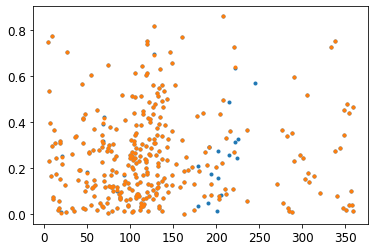

In [1259]:
plt.plot(goal.direction_avg, np.abs(goal.speed_diff),'.')
plt.plot(reorg_ddf.direction_avg, np.abs(reorg_ddf.speed_diff),'.')

## regression analysis

In [1485]:
df1=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/10.20.20_spatial.hdf')
df2=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/7.7.21_spatial.hdf')
df3=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/9.26.21_spatial.hdf')
df4=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/10.29.21_spatial.hdf')
df5=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/10.30.21_spatial.hdf')
df6=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/1.8.22_spatial.hdf')
df7=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/1.11.22_spatial.hdf')
df8=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/1.15.22_spatial.hdf')
df9=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/4.30.22_spatial.hdf')
df10=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/5.1.22_spatial.hdf')
df11=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/5.2.22_spatial.hdf')
df12=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/6.1.22_spatial.hdf')
df13=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/6.3.22_spatial.hdf')
df14=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/6.7.22_spatial.hdf')
df15=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/6.8.22_spatial.hdf')
df16=pd.read_hdf('/Users/jomammahoule1993/Desktop/hdf_dfs_for_paper/10min_avg_spatialregresions_basedonxyz/6.22.22_spatial.hdf')
df1

,environment,distance,speed_avg,direction_avg,direction_diff,speed_diff,control_D_100,control_S2_100,group,cos_direction_avg,sin_direction_avg,speed_diff_abs
0,0.001,21.45,1.349808,105.257773,28.590000,0.109370,35.77,1.632,1.0,-0.263162,0.964752,0.109370
1,0.001,21.45,1.431984,145.077525,24.039667,-0.026000,18.84,2.379,1.0,-0.819927,0.572468,0.026000
2,0.001,21.45,1.619160,149.547802,25.115167,0.057457,21.28,2.085,1.0,-0.862052,0.506819,0.057457
3,0.001,21.45,1.721084,149.399888,20.926833,-0.168135,24.45,1.366,1.0,-0.860741,0.509043,0.168135
4,0.001,21.45,1.784912,179.502089,27.386333,-0.020310,30.68,2.284,1.0,-0.999962,0.008690,0.020310
...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.001,119.87,4.984498,205.540113,5.844500,0.510947,35.97,1.352,1.0,-0.902284,-0.431143,0.510947
556,0.001,119.87,4.618164,202.926146,5.876667,0.637965,45.82,0.919,1.0,-0.921008,-0.389544,0.637965
557,0.001,119.87,5.150205,206.196001,4.783500,0.786037,39.60,1.247,1.0,-0.897289,-0.441443,0.786037
558,0.001,119.87,5.431272,205.256679,4.012833,0.511593,49.58,1.132,1.0,-0.904405,-0.426674,0.511593


In [1486]:
all_df=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]

In [1487]:
alldf=pd.concat(all_df)

In [1490]:
#normalize pandas columns
normalized_data = alldf.iloc[:,0:len(alldf)].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))

normalized_data

,environment,distance,speed_avg,direction_avg,direction_diff,speed_diff,control_D_100,control_S2_100,group,cos_direction_avg,sin_direction_avg,speed_diff_abs
0,-1.350449,-0.526766,-0.224929,-1.196496,-0.937937,0.398569,0.884956,-1.064891,-1.530475,-0.000413,1.894268,-0.667631
1,-1.350449,-0.526766,-0.156177,-0.711723,-1.126739,0.040426,-0.908596,-0.458668,-1.530475,-0.882807,1.305688,-0.992631
2,-1.350449,-0.526766,0.000425,-0.657301,-1.082114,0.261226,-0.650104,-0.697262,-1.530475,-0.949569,1.207190,-0.870000
3,-1.350449,-0.526766,0.085699,-0.659102,-1.255896,-0.335617,-0.314276,-1.280762,-1.530475,-0.947491,1.210526,-0.438548
4,-1.350449,-0.526766,0.139100,-0.292632,-0.987880,0.055478,0.345725,-0.535765,-1.530475,-1.168137,0.459800,-1.014809
...,...,...,...,...,...,...,...,...,...,...,...,...
310,-0.388139,4.313271,-0.421995,1.182451,1.649095,0.754296,0.046976,0.209232,1.725549,1.225010,-0.843798,-0.143484
311,-0.388139,4.313271,-0.010057,-0.997120,-0.027891,1.396235,-0.836557,0.130512,1.725549,-0.414601,1.724209,0.802384
312,-0.388139,4.313271,-0.233265,-1.348303,0.798099,0.565773,-0.838676,0.070458,1.725549,0.339566,1.945378,-0.421264
313,-0.388139,4.313271,-0.009332,-0.921012,0.032859,1.943498,-0.702014,0.705897,1.725549,-0.556595,1.630918,1.608751


In [1491]:
mod = smf.gls(formula='direction_diff ~ speed_avg*environment + distance*environment + control_D_100*environment', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:         direction_diff   R-squared:                       0.663
Model:                            GLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     40.07
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           1.36e-08
Time:                        10:00:44   Log-Likelihood:                -6342.2
No. Observations:                7244   AIC:                         1.270e+04
Df Residuals:                    7236   BIC:                         1.276e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

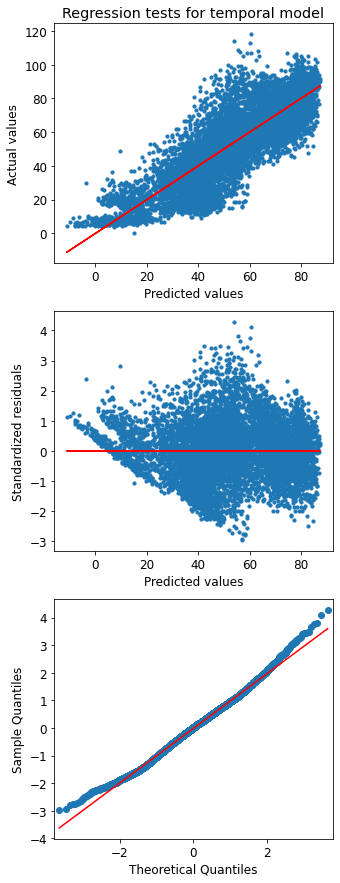

In [1492]:
mod = smf.gls(formula='direction_diff ~ speed_avg*environment + distance*environment + control_D_100*environment', data=alldf)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
#print(res.summary())


mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15))

slope, intercept = np.polyfit(res.fittedvalues, alldf.direction_diff, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('Regression tests for temporal model')
ax[0].scatter(res.fittedvalues, alldf.direction_diff, s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted values')
ax[0].set_ylabel ('Actual values')


slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted values')
ax[1].set_ylabel ('Standardized residuals')

sm.qqplot(res.resid_pearson, line='q', ax=ax[2])

plt.show()

In [1507]:
mod = smf.gls(formula='speed_diff_abs ~ cos_direction_avg + sin_direction_avg + distance*environment + control_S2_100*environment', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:         speed_diff_abs   R-squared:                       0.080
Model:                            GLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     7.587
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           0.000535
Time:                        10:05:53   Log-Likelihood:                -9975.1
No. Observations:                7244   AIC:                         1.997e+04
Df Residuals:                    7236   BIC:                         2.002e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

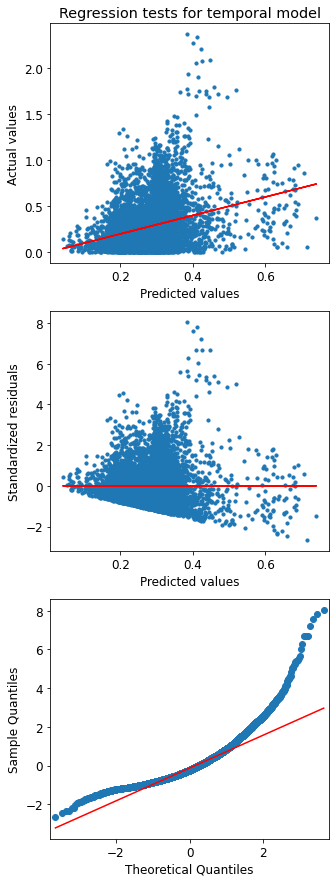

In [1508]:
mod = smf.gls(formula='speed_diff_abs ~ cos_direction_avg + sin_direction_avg +  distance*environment + control_S2_100*environment', data=alldf)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
#print(res.summary())


mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15))

slope, intercept = np.polyfit(res.fittedvalues, alldf.speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('Regression tests for temporal model')
ax[0].scatter(res.fittedvalues, alldf.speed_diff_abs, s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted values')
ax[0].set_ylabel ('Actual values')


slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted values')
ax[1].set_ylabel ('Standardized residuals')

sm.qqplot(res.resid_pearson, line='q', ax=ax[2])

plt.show()

## plotting

In [1474]:
desertchunks=pd.concat([df1, df7,df8,df12,df13])
forestchunks=pd.concat([df2,df4,df14,df15,df16])
urbanchunks=pd.concat([df3,df5,df6,df9,df10,df11])
allchunks=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]
desert=0,6,7,11,12
forest=1,3,13,14,15
urban=2,4,5,8,9,10

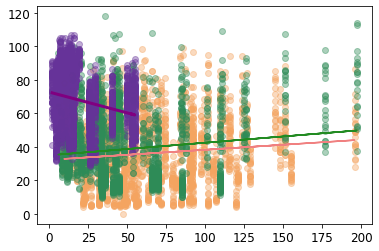

In [1430]:
##distance
#desert
slope_d1, intercept_d1 = np.polyfit(desertchunks.distance, desertchunks.direction_diff, 1)
abline_values_desertdist = [slope_d1 * i + intercept_d1 for i in desertchunks.distance]
plt.scatter(desertchunks.distance, desertchunks.direction_diff,alpha=.4, color='sandybrown')
plt.plot(desertchunks.distance, abline_values_desertdist, color='lightcoral')
#forest
slope_f1, intercept_f1 = np.polyfit(forestchunks.distance, forestchunks.direction_diff, 1)
abline_values_forestdist = [slope_f1 * i + intercept_f1 for i in forestchunks.distance]
plt.scatter(forestchunks.distance, forestchunks.direction_diff,  alpha=.4, color='seagreen')
plt.plot(forestchunks.distance, abline_values_forestdist, 'forestgreen')
#urban
slope_u1, intercept_u1 = np.polyfit(urbanchunks.distance, urbanchunks.direction_diff, 1)
abline_values_urbandist = [slope_u1 * i + intercept_u1 for i in urbanchunks.distance]
plt.scatter(urbanchunks.distance, urbanchunks.direction_diff, alpha=.4,color= 'rebeccapurple')
plt.plot(urbanchunks.distance, abline_values_urbandist, 'purple', linewidth=3)


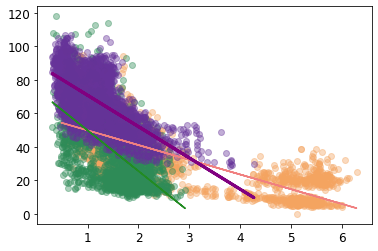

In [1431]:
##speed

#desert
slope_d2, intercept_d2 = np.polyfit(desertchunks.speed_avg, desertchunks.direction_diff, 1)
abline_values_desertspeed = [slope_d2 * i + intercept_d2 for i in desertchunks.speed_avg]
plt.scatter(desertchunks.speed_avg, desertchunks.direction_diff, alpha=.4, color='sandybrown')
plt.plot(desertchunks.speed_avg, abline_values_desertspeed, color='lightcoral')

#forest
slope_f2, intercept_f2 = np.polyfit(forestchunks.speed_avg, forestchunks.direction_diff, 1)
abline_values_forestspeed = [slope_f2 * i + intercept_f2 for i in forestchunks.speed_avg]
plt.scatter(forestchunks.speed_avg, forestchunks.direction_diff, alpha=.4, color='seagreen')
plt.plot(forestchunks.speed_avg, abline_values_forestspeed, color='forestgreen')

#urban
slope_u2, intercept_u2 = np.polyfit(urbanchunks.speed_avg, urbanchunks.direction_diff, 1)
abline_values_urbanspeed = [slope_u2 * i + intercept_u2 for i in urbanchunks.speed_avg]
plt.scatter(urbanchunks.speed_avg, urbanchunks.direction_diff,alpha=.4,color= 'rebeccapurple',)
plt.plot(urbanchunks.speed_avg, abline_values_urbanspeed, color= 'purple', linewidth=3)

<ipython-input-1432-cbed14250fd7>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([0,20, 40, 60, 80, 100, 120, 140, 160, 180, 200])


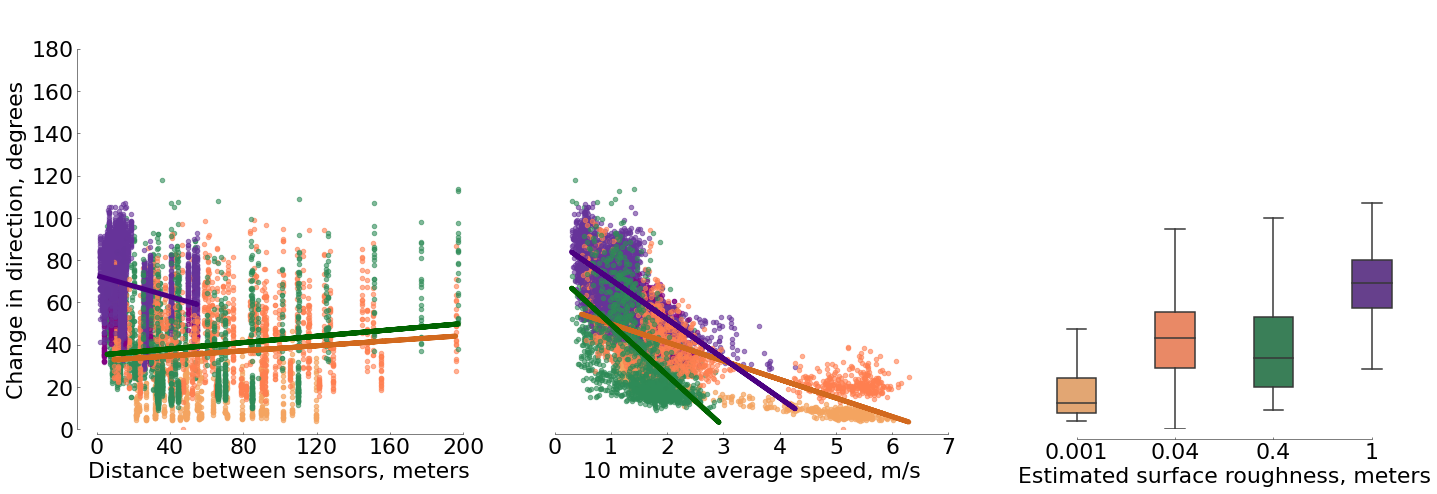

In [1432]:
mpl.rcParams.update({'font.size': 22})
allchunks=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]
c=['sandybrown', 'seagreen', 'rebeccapurple', 'seagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'purple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'seagreen', 'seagreen', 'seagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7))

ax[0].scatter(allchunks[0].distance, allchunks[0].direction_diff, s=20, color=c[0], alpha=.7, label='desert/valley')
ax[1].scatter(allchunks[0].speed_avg, allchunks[0].direction_diff,  s=20, color=c[0], alpha=.7, label='desert/valley')
ax[0].scatter(allchunks[1].distance, allchunks[1].direction_diff, s=20, color=c[1], alpha=.6, label='forest')
ax[1].scatter(allchunks[1].speed_avg, allchunks[1].direction_diff,  s=20, color=c[1], alpha=.6, label='forest')
ax[0].scatter(allchunks[2].distance, allchunks[2].direction_diff, s=20, color=c[2], alpha=.6, label='urban')
ax[1].scatter(allchunks[2].speed_avg, allchunks[2].direction_diff,  s=20, color=c[2], alpha=.6, label='urban')

# add mean lines
ax[0].plot(desertchunks.distance, abline_values_desertdist, 'chocolate', linewidth=5)
ax[0].plot(forestchunks.distance, abline_values_forestdist, 'darkgreen',linewidth=5)
ax[0].plot(urbanchunks.distance, abline_values_urbandist, 'indigo', linewidth=5)

ax[1].plot(desertchunks.speed_avg, abline_values_desertspeed, 'chocolate', linewidth=5)
ax[1].plot(forestchunks.speed_avg, abline_values_forestspeed, 'darkgreen',linewidth=5)
ax[1].plot(urbanchunks.speed_avg, abline_values_urbanspeed, 'indigo', linewidth=5)

for i in range(3,16):
    ax[0].scatter(allchunks[i].distance, allchunks[i].direction_diff, s=20, color=c[i], alpha=.6)
    ax[1].scatter(allchunks[i].speed_avg, allchunks[i].direction_diff,  s=20, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].environment, allchunks[i].direction,  s=20, color=c[i], alpha=.6)

    
sns.boxplot(x=alldf.environment, y=alldf.direction_diff, showfliers=False, palette=['sandybrown','coral', 'seagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[2].set_xticklabels([.001,.04, .4, 1])
ax[0].set_yticklabels([0,20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
ax[0].set_ylim(0,180)
ax[1].set_ylim(0,180) 
ax[2].set_ylim(0,180) 
#ax[1].set_xlim(0,3.5) 
#ax[0].set_xlim(0,100)
ax[0].set_ylabel('Change in direction, degrees')
ax[0].set_xlabel('Distance between sensors, meters')  
#ax[1].set_ylabel('Change in direction, degrees')
ax[1].set_xlabel('10 minute average speed, m/s')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')

#ax[0].legend(bbox_to_anchor=(1,1))
#ax[1].legend(bbox_to_anchor=(1,1))
#ax[2].legend(bbox_to_anchor=(1,1))



fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=[0,20,40,60,80,100,120,140,160,180],
                                 xticks=[0,40,80,120,160, 200],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,1,2,3,4, 5,6,7],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)


# set yticklabels
#evenyticks = np.arange(0, 180+20, 20)
#yticklabels = [['$' + str(y) + '^{\circ}$', ''] for y in evenyticks]
#yticklabels = np.ravel(yticklabels)[0:-1]
#ax[0].set_yticklabels(yticklabels)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 
                                 tick_length=2.5,
                                 spine_locations={ 'bottom': 10},
                                 linewidth=0.5)


#ax[0].spines['left'].set_color('black')
#ax[0].spines['bottom'].set_color('black')
##ax[1].spines['left'].set_color('black')
#ax[1].spines['bottom'].set_color('black')
#ax[2].spines['left'].set_color('black')
#ax[2].spines['bottom'].set_color('black')

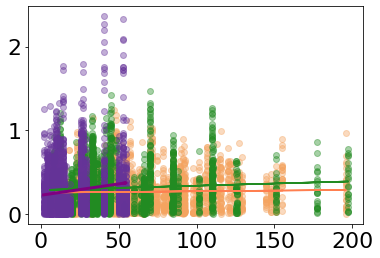

In [1437]:
#desert
slope_d3, intercept_d3 = np.polyfit(desertchunks.distance, desertchunks.speed_diff_abs, 1)
abline_values_desertdist2 = [slope_d3 * i + intercept_d3 for i in desertchunks.distance]
plt.scatter(desertchunks.distance, desertchunks.speed_diff_abs, alpha=.4, color='sandybrown')
plt.plot(desertchunks.distance, abline_values_desertdist2, 'coral')

#forest
slope_f3, intercept_f3 = np.polyfit(forestchunks.distance, forestchunks.speed_diff_abs, 1)
abline_values_forestdist2 = [slope_f3 * i + intercept_f3 for i in forestchunks.distance]
plt.scatter(forestchunks.distance, forestchunks.speed_diff_abs,  alpha=.4,color='forestgreen')
plt.plot(forestchunks.distance, abline_values_forestdist2, 'forestgreen')

#urban
slope_u3, intercept_u3 = np.polyfit(urbanchunks.distance, urbanchunks.speed_diff_abs, 1)
abline_values_urbandist2 = [slope_u3 * i + intercept_u3 for i in urbanchunks.distance]
plt.scatter(urbanchunks.distance, urbanchunks.speed_diff_abs, alpha=.4, color='rebeccapurple')
plt.plot(urbanchunks.distance, abline_values_urbandist2, 'purple', linewidth=3)

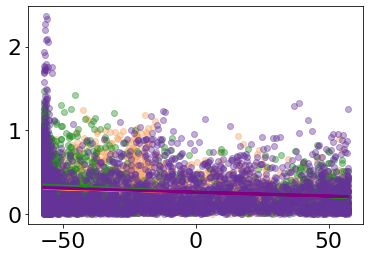

In [1438]:
#desert
slope_d4, intercept_d4 = np.polyfit(desertchunks.sin_direction_avg, desertchunks.speed_diff_abs, 1)
abline_values_desertspeed2 = [slope_d4 * i + intercept_d4 for i in desertchunks.sin_direction_avg]
plt.scatter(desertchunks.sin_direction_avg, desertchunks.speed_diff_abs, alpha=.4, color='sandybrown')
plt.plot(desertchunks.sin_direction_avg, abline_values_desertspeed2, 'coral')

#forest
slope_f4, intercept_f4 = np.polyfit(forestchunks.sin_direction_avg, forestchunks.speed_diff_abs, 1)
abline_values_forestspeed2 = [slope_f4 * i + intercept_f4 for i in forestchunks.sin_direction_avg]
plt.scatter(forestchunks.sin_direction_avg, forestchunks.speed_diff_abs,  alpha=.4,color='forestgreen')
plt.plot(forestchunks.sin_direction_avg, abline_values_forestspeed2, 'forestgreen')

#urban
slope_u4, intercept_u4 = np.polyfit(urbanchunks.sin_direction_avg, urbanchunks.speed_diff_abs, 1)
abline_values_urbanspeed2 = [slope_u4 * i + intercept_u4 for i in urbanchunks.sin_direction_avg]
plt.scatter(urbanchunks.sin_direction_avg, urbanchunks.speed_diff_abs, alpha=.4, color='rebeccapurple')
plt.plot(urbanchunks.sin_direction_avg, abline_values_urbanspeed2, 'purple', linewidth=3)

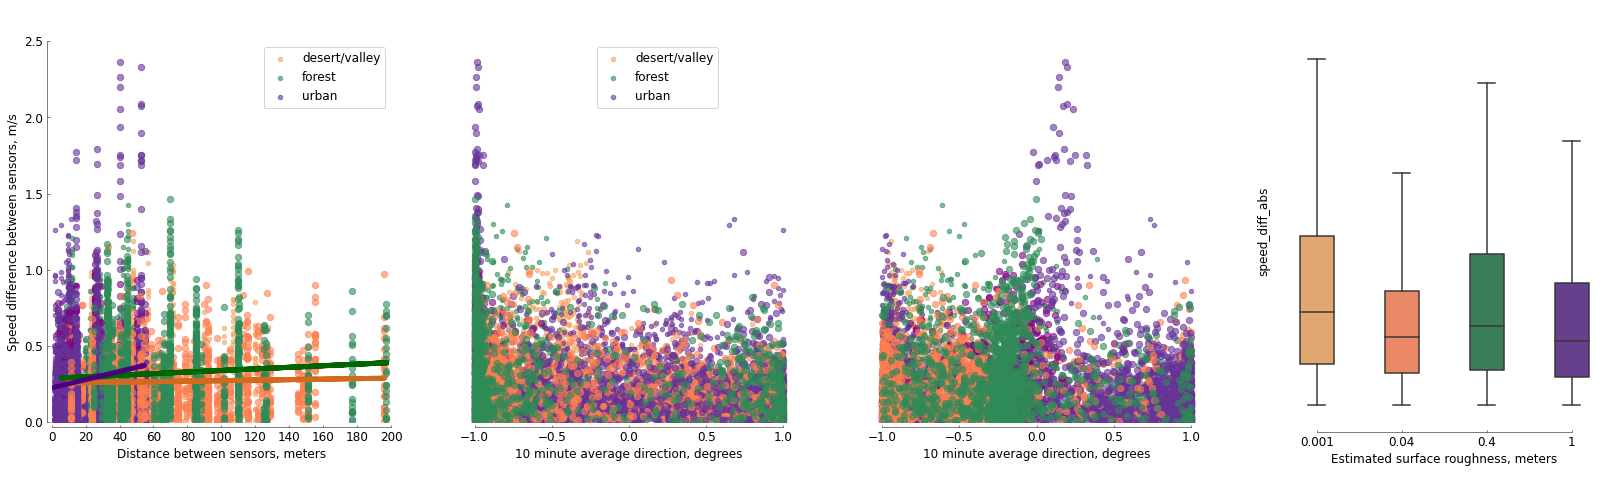

In [1479]:
##### mpl.rcParams.update({'font.size': 22})

c=['sandybrown', 'seagreen', 'rebeccapurple', 'seagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'purple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'seagreen', 'seagreen', 'seagreen']

fig, ax =plt.subplots(nrows=1, ncols=4, figsize=(28,7))

ax[0].scatter(allchunks[0].distance, allchunks[0].speed_diff_abs, s=20, color=c[0], alpha=.6, label='desert/valley')
ax[0].scatter(allchunks[1].distance, allchunks[1].speed_diff_abs, s=20, color=c[1], alpha=.6, label='forest')
ax[0].scatter(allchunks[2].distance, allchunks[2].speed_diff_abs, s=20, color=c[2], alpha=.6, label='urban')
             
ax[1].scatter(allchunks[0].sin_direction_avg, allchunks[0].speed_diff_abs,  s=20, color=c[0], alpha=.6, label='desert/valley')
ax[1].scatter(allchunks[1].sin_direction_avg, allchunks[1].speed_diff_abs,  s=20, color=c[1], alpha=.6, label='forest')              
ax[1].scatter(allchunks[2].sin_direction_avg, allchunks[2].speed_diff_abs,  s=20, color=c[2], alpha=.6, label='urban')

ax[2].scatter(allchunks[0].cos_direction_avg, allchunks[0].speed_diff_abs,  s=20, color=c[0], alpha=.6, label='desert/valley')
ax[2].scatter(allchunks[1].cos_direction_avg, allchunks[1].speed_diff_abs,  s=20, color=c[1], alpha=.6, label='forest')
ax[2].scatter(allchunks[2].cos_direction_avg, allchunks[2].speed_diff_abs,  s=20, color=c[2], alpha=.6, label='urban')


# add mean lines
ax[0].plot(desertchunks.distance, abline_values_desertdist2, 'chocolate', linewidth=5)
ax[0].plot(forestchunks.distance, abline_values_forestdist2, 'darkgreen',linewidth=5)
ax[0].plot(urbanchunks.distance, abline_values_urbandist2, 'indigo', linewidth=5)

#ax[1].plot(desertchunks.direction_avg, abline_values_desertspeed2, 'chocolate', linewidth=5)
#ax[1].plot(forestchunks.direction_avg, abline_values_forestspeed2, 'darkgreen',linewidth=5)
#ax[1].plot(urbanchunks.direction_avg, abline_values_urbanspeed2, 'indigo', linewidth=5)


for i in range(3,16):
    ax[0].scatter(allchunks[i].distance,  allchunks[i].speed_diff_abs, s=40, color=c[i], alpha=.6)
    ax[1].scatter(allchunks[i].sin_direction_avg, allchunks[i].speed_diff_abs,  s=40, color=c[i], alpha=.6)
    ax[2].scatter(allchunks[i].cos_direction_avg, allchunks[i].speed_diff_abs,  s=40, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].environment, allchunks[i].direction,  s=20, color=c[i], alpha=.6)

    
sns.boxplot(x=alldf.environment, y=alldf.speed_diff_abs, showfliers=False, palette=['sandybrown','coral', 'seagreen', 'rebeccapurple',], width=.4, ax=ax[3])
ax[3].set_xticklabels([.001,.04, .4, 1])
ax[0].set_xlim(0,150)
#ax[1].set_ylim(0,180) 
#ax[2].set_ylim(0,180) 
#ax[1].set_xlim(0,360) 
ax[0].set_ylim(0,2.5)
ax[1].set_ylim(0,2.5)
ax[2].set_ylim(0,2.5)
ax[0].set_ylabel('Speed difference between sensors, m/s')
ax[0].set_xlabel('Distance between sensors, meters')  
#ax[1].set_ylabel('Change in direction, degrees')
ax[1].set_xlabel('10 minute average direction, degrees')
ax[2].set_xlabel('10 minute average direction, degrees')
ax[2].set_ylabel('')
ax[3].set_xlabel('Estimated surface roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')

ax[0].legend(bbox_to_anchor=(1,1))
ax[1].legend(bbox_to_anchor=(.78,1))
#ax[2].legend(bbox_to_anchor=(1,1))



fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                
                                 xticks=[0,20,40,60,80,100,120,140, 160, 180, 200],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[-1,-.5,0,.5,1],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 xticks=[-1,-.5,0,.5,1],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)


fifi.mpl_functions.adjust_spines(ax[3], [ 'bottom'],
                                 #xticks=[.001,.04,.4,1],
                                 tick_length=2.5,
                                 spine_locations={ 'bottom': 10},
                                 linewidth=0.5)


#ax[0].spines['left'].set_color('black')
#ax[0].spines['bottom'].set_color('black')
##ax[1].spines['left'].set_color('black')
#ax[1].spines['bottom'].set_color('black')
#ax[2].spines['left'].set_color('black')
#ax[2].spines['bottom'].set_color('black')